In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
import matplotlib.pyplot as plt

from small_circles import *

from ipywidgets import interact

In [201]:
def graphical_method(data):
    difference = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            a = data[i]
            b = data[j]
            c = a - b
            difference.append(c/c.length)
    return difference

def graphical_method1(data):
    difference = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            a = data[i]
            b = data[j]
            c = (a + b)/2.
            ab = a.normalized_cross_with(b)
            c_ = ab.get_rotation_matrix(radians(90.)).dot(c)
            c_ = c_ if c_[2] < 0 else -c_
            c_ /= np.linalg.norm(c_)
            difference.append(c_)
    return difference

def graphical_method(data, sample_ratio=0.5):
    n = int(len(data)/sample_ratio)
    difference = []
    lengths = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            a = data[i]
            b = data[j]
            c = a - b
            difference.append(c/c.length)
            lengths.append(c.length)
    return np.array(difference)[np.argsort(-np.array(lengths))[:n]]

def fit_eigen(data):
    direction_tensor = np.dot(np.transpose(data), data)
    eigenvalues, eigenvectors = np.linalg.eigh(direction_tensor)
    axis = Vector(eigenvectors[:, eigenvalues.argmax()])
    return axis/axis.length

In [203]:
@interact(kappa=(50, 2000, 10),
          circle_fraction=(0.1, 1.0, 0.01),
          alpha=(0, 90, 5),
          n_pairs=(0, 100, 5),
          offset=(0, 360, 5),
          sample_ratio=(0.1, 200, 0.05))
def foo(kappa=500, alpha = 60, circle_fraction=.33, n_pairs=21, offset=45, sample_ratio = 0.5):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot = ProjectionPlot(ax)#, projection=EqualAngle)
    plot.clear_diagram()

    apical_angle = radians(alpha)

    sc_axis = Vector.from_attitude(90, 60)
    plot.as_lines(sc_axis.get_small_circle(apical_angle), color="blue")
    plot.as_lines(sc_axis.get_great_circle(), color="k")
    plot.as_points(sc_axis, marker='*', ms=12, c='b')
    plot.base_net(5, 5)
    offset = 90. - 360.*circle_fraction/2.

    sc_points = sc_axis.get_small_circle(apical_angle, offset=radians(offset))[0]
    n = len(sc_points)
    axes = []
    for _ in range(1):
#         kappa = 500
#         circle_fraction = 0.25
#         n_pairs = 20
        noisy_data = [sample_fisher(sc_points[np.random.randint(int(n*circle_fraction))], kappa, 1)[0] for _ in range(n_pairs)]
        plot.as_points(noisy_data, ms=1)
        diff = graphical_method1(noisy_data)#, sample_ratio)
        print(len(diff))
        plot.as_points(diff, ms=1, c="g")
        calculated_axis = fit_girdle(diff)
        if calculated_axis[-1] > 0:
            calculated_axis = -calculated_axis
        axes.append(calculated_axis)
        plot.as_points(calculated_axis, marker='*', ms=5, c='r')
#         bingham_axis = fit_small_circle(noisy_data)
#         if bingham_axis[-1] > 0:
#             bingham_axis = -bingham_axis
        #plot.as_points(bingham_axis, marker='*', ms=5, c='c')
        #plot.as_lines(bingham_axis.arc_to(sc_axis))
    plot.as_points(fit_eigen(axes), marker='*', ms=12, c='k')
    plot.as_points(sc_axis, marker='*', ms=12, c='b')
    print(degrees(sc_axis.angle_with(-fit_eigen(axes))))

A Jupyter Widget

In [193]:
def intersect(a, b, c, d):
    return (a.normalized_cross_with(b)).normalized_cross_with(c.normalized_cross_with(d))

def pascal(a, b, c, d, e, X):
    F = []
    p = intersect(a, b, d, e)
    for x in X:
        q = intersect(p, x, c, d)
        r = intersect(p, x, b, c)
        f = intersect(a, q, e, r)
        F.append(f)
    return F

def pascal2(a, b, c, d, e, x):
    p = intersect(a, b, d, e)
    q = intersect(p, x, c, d)
    r = intersect(p, x, b, c)
    return intersect(a, q, e, r)

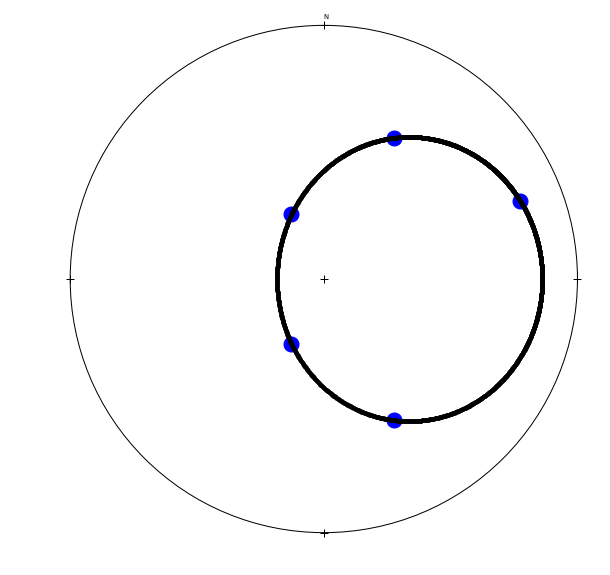

In [171]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = ProjectionPlot(ax)#, projection=EqualAngle)
plot.clear_diagram()
# a = Vector.from_attitude(120, 20)
# b = Vector.from_attitude(140, 45)
# c = Vector.from_attitude(90, 30)
# d = Vector.from_attitude(160, 80)
# e = Vector.from_attitude(200, 10)
a, b, c, d, e = Vector.from_attitude(90, 60).get_small_circle(radians(45), step = radians(60))[0][:5]
for p in (a, b, c, d, e):
    plot.as_points(p, c='blue', ms = 15)
    
sc_axis = Vector.from_attitude(90, 90)
sc_points = sc_axis.get_great_circle(step=radians(0.1))[0]

F = pascal(a, b, c, d, e, sc_points)
F.append(F[0])
plot.as_lines([F,-np.array(F)])
plot.as_points(F)

In [162]:
def fit_quadric(data):
    A = []
    for x, y, z in data:
        A.append([x*x, y*y, z*z, x*y, y*z, z*x, x, y, z])
    b = np.ones(len(data))
    return np.array(A), b

In [183]:
stetsky = np.loadtxt(
    "C:\\Users\\arthur.endlein\\Documents\\projects\\repos\\autti\\Examples\\stetskyex3.txt",
    skiprows=1,
    delimiter=";")

Wall time: 25.9 s


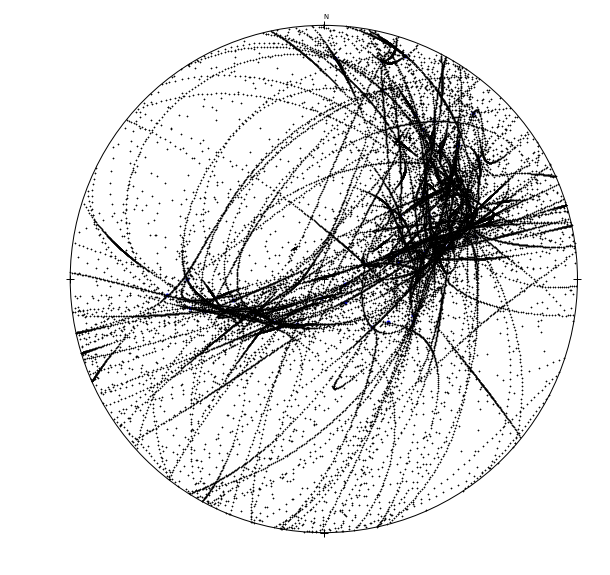

In [197]:
%%time
st = -dcos_line(stetsky)

fig, ax = plt.subplots(figsize=(10, 10))
plot = ProjectionPlot(ax)#, projection=EqualAngle)
plot.clear_diagram()

X = sc_axis.get_great_circle(step=radians(1))[0]

plot.as_points(st, c="blue")
for _ in range(200):
    a, b, c, d, e = [Vector(i) for i in st[np.random.choice(len(st), 5, False)]]
#     x = X[_]
    plot.as_points(pascal(a, b, c, d, e, X), ms=0.5)